In [4]:
!pip install --upgrade bottleneck


  Attempting uninstall: bottleneck
    Found existing installation: Bottleneck 1.3.8
    Uninstalling Bottleneck-1.3.8:
      Successfully uninstalled Bottleneck-1.3.8


In [5]:
!pip install --upgrade pandas


In [6]:
!pip install --upgrade numpy scipy


In [7]:
!# Install necessary packages
!pip install transformers datasets rouge_score nltk xgboost matplotlib seaborn
!pip install spacy
!python -m spacy download en_core_web_sm


/anaconda/envs/azureml_py38/lib/python3.9/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 110.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [8]:

import pandas as pd
import numpy as np
import torch
from transformers import (BartTokenizer, BartForConditionalGeneration, 
                          T5Tokenizer, T5ForConditionalGeneration, 
                          PegasusTokenizer, PegasusForConditionalGeneration, 
                          BertTokenizer, BertForSequenceClassification)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from datasets import load_dataset
from rouge_score import rouge_scorer
import nltk
from nltk.translate.bleu_score import sentence_bleu
import xgboost as xgb
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer


/anaconda/envs/azureml_py38/lib/python3.9/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [9]:

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')

# Load SpaCy's English model
nlp = spacy.load('en_core_web_sm')

# Load the WikiText dataset
dataset = load_dataset('wikitext', 'wikitext-103-raw-v1')

# Accessing the dataset directly and converting to a list of texts
texts = dataset['test']['text'][:200]  # Load a small subset for demonstration

[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
train_texts, temp_texts = train_test_split(texts, test_size=0.2, random_state=42)
val_texts, test_texts = train_test_split(temp_texts, test_size=0.5, random_state=42)

In [25]:
from collections import Counter

[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


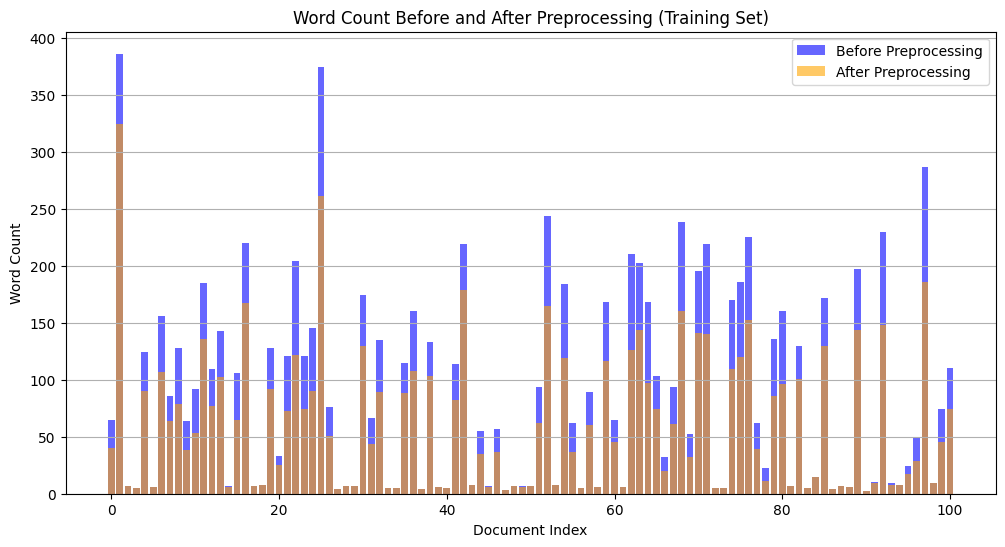

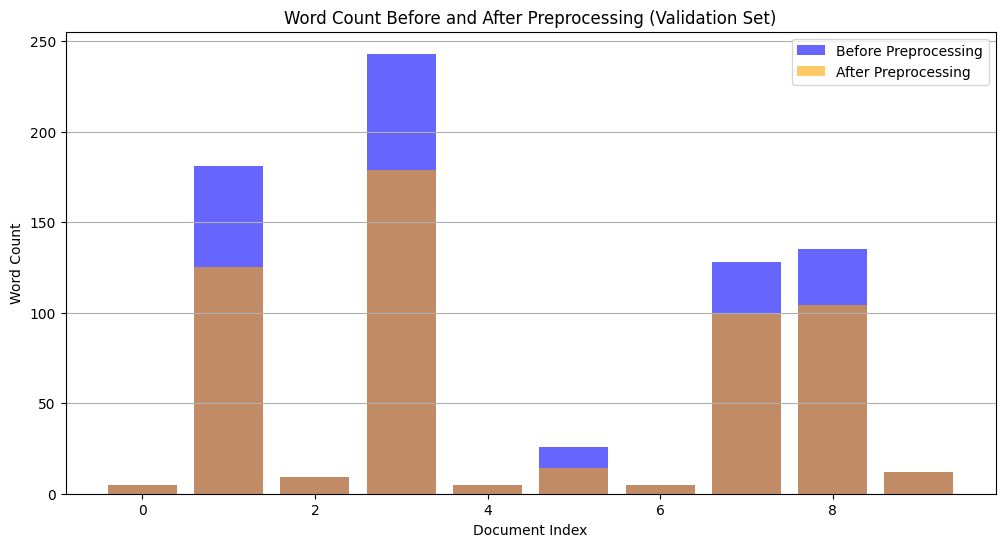

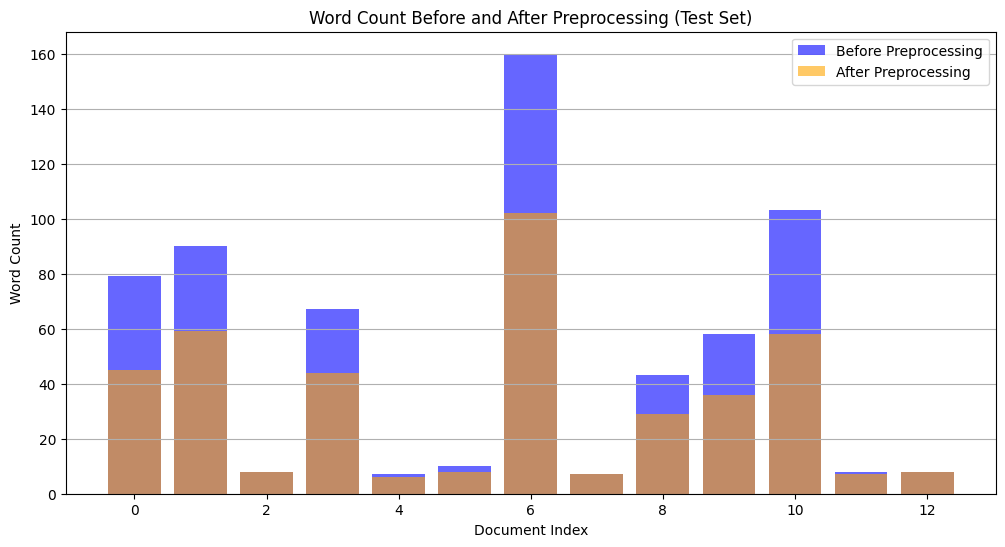

In [36]:
import nltk
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords

# Load SpaCy's English model
nlp = spacy.load('en_core_web_sm')

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Function to remove stop words
def remove_stop_words(words):
    return [word for word in words if word.lower() not in stop_words]

def tokenize_and_preprocess(text):
    # Sentence and word tokenization
    sentences = nltk.sent_tokenize(text)
    words = nltk.word_tokenize(text)

    # SpaCy processing
    doc = nlp(text)
    spacy_tokens = [token.text for token in doc if not token.is_punct and not token.is_space]
    spacy_lemmatized_tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]

    return sentences, words, spacy_tokens, spacy_lemmatized_tokens

def lemmatize_words(words):
    lemmatizer = nltk.WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def stem_words(words):
    stemmer = nltk.PorterStemmer()
    return [stemmer.stem(word) for word in words]

def preprocess_texts(texts):
    preprocessed_texts = []
    all_words = []

    for text in texts:
        if not text.strip():  # Skip empty texts
            continue
        
        sentences, words, spacy_tokens, spacy_lemmatized_tokens = tokenize_and_preprocess(text)
        
        lemmatized_words = lemmatize_words(words)
        lemmatized_words = remove_stop_words(lemmatized_words)  # Remove stop words
        stemmed_words = stem_words(words)
        stemmed_words = remove_stop_words(stemmed_words)  # Remove stop words

        # Collecting all words for visualization
        all_words.extend(words)

        preprocessed_texts.append({
            'original': text,
            'sentences': sentences,
            'words': words,
            'lemmatized_words': lemmatized_words,
            'stemmed_words': stemmed_words,
            'spacy_tokens': spacy_tokens,
            'spacy_lemmatized_tokens': spacy_lemmatized_tokens,
        })

    return preprocessed_texts, all_words

# Process the texts for training, validation, and test sets
preprocessed_train_data, all_train_words = preprocess_texts(train_texts)
preprocessed_val_data, all_val_words = preprocess_texts(val_texts)
preprocessed_test_data, all_test_words = preprocess_texts(test_texts)

# Calculate before and after counts for visualization
before_counts_train = [len(nltk.word_tokenize(text)) for text in train_texts if text.strip()]
after_counts_train = [len(text['lemmatized_words']) for text in preprocessed_train_data]

before_counts_val = [len(nltk.word_tokenize(text)) for text in val_texts if text.strip()]
after_counts_val = [len(text['lemmatized_words']) for text in preprocessed_val_data]

before_counts_test = [len(nltk.word_tokenize(text)) for text in test_texts if text.strip()]
after_counts_test = [len(text['lemmatized_words']) for text in preprocessed_test_data]

# Visualization function
def visualize_preprocessing(before_counts, after_counts, dataset_name):
    # Visualization: Before and After Word Count Comparison
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(before_counts)), before_counts, alpha=0.6, label='Before Preprocessing', color='blue')
    plt.bar(range(len(after_counts)), after_counts, alpha=0.6, label='After Preprocessing', color='orange')
    plt.title(f'Word Count Before and After Preprocessing ({dataset_name})')
    plt.xlabel('Document Index')
    plt.ylabel('Word Count')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

# Call the visualization for each dataset
visualize_preprocessing(before_counts_train, after_counts_train, 'Training Set')
visualize_preprocessing(before_counts_val, after_counts_val, 'Validation Set')
visualize_preprocessing(before_counts_test, after_counts_test, 'Test Set')


In [37]:
print("Before Counts:", before_counts)
print("After Counts:", after_counts)


Before Counts: [4, 168, 160, 5, 9, 135, 185, 9, 181, 219, 5, 7, 7, 7, 4, 103, 109, 5, 184, 8, 89, 57, 58, 121, 62, 136, 168, 62, 7, 186, 26, 90, 160, 23, 52, 7, 170, 8, 160, 79, 43, 55, 5, 24, 7, 103, 65, 8, 94, 67, 76, 8, 238, 106, 32, 74, 5, 64, 92, 128, 230, 121, 66, 10, 65, 287, 225, 5, 204, 114, 33, 9, 128, 143, 115, 49, 7, 135, 156, 7, 197, 195, 6, 243, 220, 6, 86, 174, 133, 124, 6, 244, 6, 2, 8, 8, 7, 15, 5, 5, 7, 4, 7, 3, 12, 10, 5, 5, 6, 8, 110, 210, 5, 94, 202, 128, 145, 7, 374, 130, 172, 7, 386, 219]
After Counts: [4, 116, 108, 5, 9, 89, 136, 9, 125, 140, 5, 7, 7, 7, 4, 74, 77, 5, 119, 8, 60, 37, 36, 74, 37, 86, 97, 39, 7, 120, 14, 59, 96, 11, 32, 7, 109, 8, 102, 45, 29, 35, 5, 17, 7, 58, 40, 8, 61, 44, 51, 8, 160, 65, 20, 45, 5, 38, 53, 79, 148, 73, 44, 9, 45, 186, 152, 5, 122, 82, 25, 8, 92, 102, 88, 29, 6, 104, 107, 6, 144, 141, 6, 179, 167, 6, 64, 130, 103, 90, 6, 165, 6, 2, 7, 8, 6, 15, 5, 5, 7, 4, 7, 3, 12, 8, 5, 5, 6, 8, 74, 126, 5, 62, 144, 100, 90, 6, 261, 101, 130,

In [38]:
# BART Summarization
def summarize_with_bart(texts):
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
    model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
    summaries = []
    for text in texts:
        inputs = tokenizer.encode("summarize: " + text, return_tensors='pt', max_length=1024, truncation=True)
        summary_ids = model.generate(inputs, max_length=150, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
        summaries.append(tokenizer.decode(summary_ids[0], skip_special_tokens=True))
    return summaries


In [39]:
# T5 Summarization
def summarize_with_t5(texts):
    tokenizer = T5Tokenizer.from_pretrained('t5-small')
    model = T5ForConditionalGeneration.from_pretrained('t5-small')
    summaries = []
    for text in texts:
        inputs = tokenizer.encode("summarize: " + text, return_tensors='pt', max_length=1024, truncation=True)
        summary_ids = model.generate(inputs, max_length=150, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
        summaries.append(tokenizer.decode(summary_ids[0], skip_special_tokens=True))
    return summaries


In [40]:
# Pegasus Summarization
def summarize_with_pegasus(texts):
    tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-xsum')
    model = PegasusForConditionalGeneration.from_pretrained('google/pegasus-xsum')
    summaries = []
    for text in texts:
        inputs = tokenizer.encode(text, return_tensors='pt', max_length=1024, truncation=True)
        summary_ids = model.generate(inputs, max_length=150, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
        summaries.append(tokenizer.decode(summary_ids[0], skip_special_tokens=True))
    return summaries

In [41]:
# Classification with BERT
def classify_with_bert(texts):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
    
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1).numpy()
    
    return predictions

In [42]:
# Classification with XGBoost
def classify_with_xgboost(texts, labels):
    vectorizer = TfidfVectorizer()  # Use TF-IDF to convert texts to features
    features = vectorizer.fit_transform(texts).toarray()
    
    model = xgb.XGBClassifier(use_label_encoder=False)
    model.fit(features, labels)
    predictions = model.predict(features)
    
    return predictions

In [43]:
# Evaluate Summarization
def evaluate_summarization(original_texts, summaries):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    bleu_scores = []
    
    for orig, sum_text in zip(original_texts, summaries):
        rouge_scores.append(scorer.score(orig, sum_text))
        bleu_scores.append(sentence_bleu([orig.split()], sum_text.split()))
    
    return rouge_scores, bleu_scores

# Classification Evaluation
def evaluate_classification(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)
    return accuracy, precision, recall

# Dummy Labels for Classification (Adjust as needed)
dummy_labels = np.random.randint(0, 2, size=len(train_texts))

# Run Summarization
bart_train_summaries = summarize_with_bart(train_texts)
t5_train_summaries = summarize_with_t5(train_texts)
pegasus_train_summaries = summarize_with_pegasus(train_texts)




You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
bert_predictions = classify_with_bert(bart_train_summaries)
xgboost_predictions = classify_with_xgboost(bart_train_summaries, dummy_labels)

### Evaluate Summarization Models
rouge_bart, bleu_bart = evaluate_summarization(train_texts, bart_train_summaries)
rouge_t5, bleu_t5 = evaluate_summarization(train_texts, t5_train_summaries)
rouge_pegasus, bleu_pegasus = evaluate_summarization(train_texts, pegasus_train_summaries)

### Evaluate Classification Models
accuracy_bert, precision_bert, recall_bert = evaluate_classification(dummy_labels, bert_predictions)
accuracy_xgboost, precision_xgboost, recall_xgboost = evaluate_classification(dummy_labels, xgboost_predictions)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:55:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 

In [53]:
# Function to extract and print ROUGE scores in a readable format
def print_rouge_scores(rouge_scores, model_name):
    print(f"ROUGE Scores ({model_name}):")
    for idx, score in enumerate(rouge_scores):
        print(f"Summary {idx + 1}:")
        print(f"  ROUGE-1: F1-Score = {score['rouge1'].fmeasure:.4f}, Precision = {score['rouge1'].precision:.4f}, Recall = {score['rouge1'].recall:.4f}")
        print(f"  ROUGE-2: F1-Score = {score['rouge2'].fmeasure:.4f}, Precision = {score['rouge2'].precision:.4f}, Recall = {score['rouge2'].recall:.4f}")
        print(f"  ROUGE-L: F1-Score = {score['rougeL'].fmeasure:.4f}, Precision = {score['rougeL'].precision:.4f}, Recall = {score['rougeL'].recall:.4f}")
        print()

# Example of printing ROUGE scores for BART
print_rouge_scores(rouge_bart, "BART")
print_rouge_scores(rouge_t5, "T5")
print_rouge_scores(rouge_pegasus, "Pegasus")


ROUGE Scores (BART):
Summary 1:
  ROUGE-1: F1-Score = 0.7609, Precision = 1.0000, Recall = 0.6140
  ROUGE-2: F1-Score = 0.7333, Precision = 0.9706, Recall = 0.5893
  ROUGE-L: F1-Score = 0.7609, Precision = 1.0000, Recall = 0.6140

Summary 2:
  ROUGE-1: F1-Score = 0.3129, Precision = 1.0000, Recall = 0.1855
  ROUGE-2: F1-Score = 0.2945, Precision = 0.9556, Recall = 0.1741
  ROUGE-L: F1-Score = 0.2925, Precision = 0.9348, Recall = 0.1734

Summary 3:
  ROUGE-1: F1-Score = 0.0000, Precision = 0.0000, Recall = 0.0000
  ROUGE-2: F1-Score = 0.0000, Precision = 0.0000, Recall = 0.0000
  ROUGE-L: F1-Score = 0.0000, Precision = 0.0000, Recall = 0.0000

Summary 4:
  ROUGE-1: F1-Score = 0.0000, Precision = 0.0000, Recall = 0.0000
  ROUGE-2: F1-Score = 0.0000, Precision = 0.0000, Recall = 0.0000
  ROUGE-L: F1-Score = 0.0000, Precision = 0.0000, Recall = 0.0000

Summary 5:
  ROUGE-1: F1-Score = 0.0000, Precision = 0.0000, Recall = 0.0000
  ROUGE-2: F1-Score = 0.0000, Precision = 0.0000, Recall = 0.0

In [50]:

# Classification Evaluation Results
print("Accuracy (BERT):", accuracy_bert)
print("Precision (BERT):", precision_bert)
print("Recall (BERT):", recall_bert)

Accuracy (BERT): 0.49375
Precision (BERT): 0.49093528368794326
Recall (BERT): 0.49375


In [51]:

print("Accuracy (XGBoost):", accuracy_xgboost)
print("Precision (XGBoost):", precision_xgboost)
print("Recall (XGBoost):", recall_xgboost)

Accuracy (XGBoost): 0.825
Precision (XGBoost): 0.8691441441441441
Recall (XGBoost): 0.825


Best ROUGE Scores (BART):
Summary 1:
  ROUGE-1: F1-Score = 0.9767, Precision = 0.9545, Recall = 1.0000
  ROUGE-2: F1-Score = 0.9756, Precision = 0.9524, Recall = 1.0000
  ROUGE-L: F1-Score = 0.9767, Precision = 0.9545, Recall = 1.0000

Summary 2:
  ROUGE-1: F1-Score = 0.9767, Precision = 0.9545, Recall = 1.0000
  ROUGE-2: F1-Score = 0.9756, Precision = 0.9524, Recall = 1.0000
  ROUGE-L: F1-Score = 0.9767, Precision = 0.9545, Recall = 1.0000



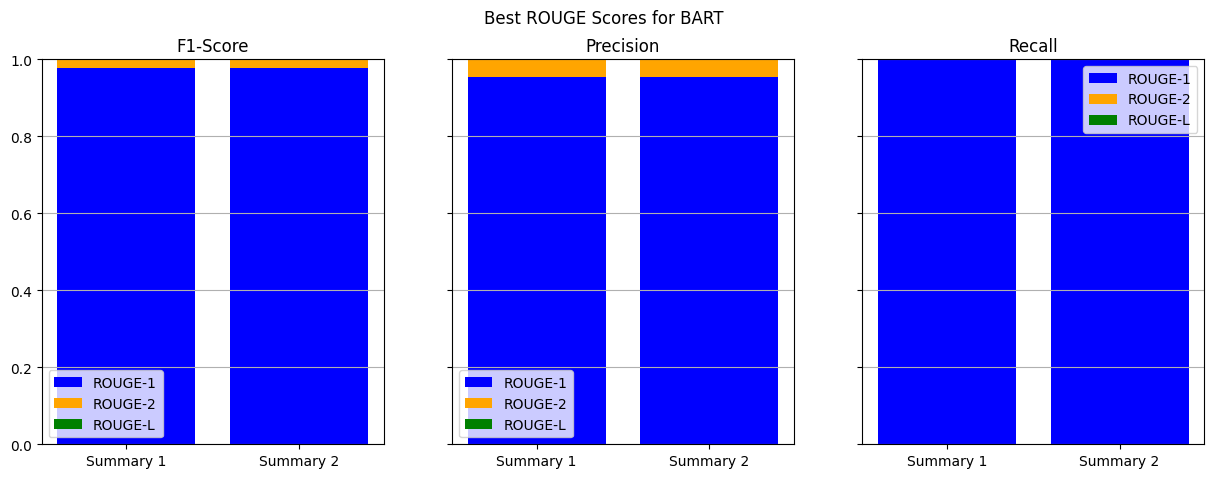

Best ROUGE Scores (T5):
Summary 1:
  ROUGE-1: F1-Score = 1.0000, Precision = 1.0000, Recall = 1.0000
  ROUGE-2: F1-Score = 0.0000, Precision = 0.0000, Recall = 0.0000
  ROUGE-L: F1-Score = 1.0000, Precision = 1.0000, Recall = 1.0000

Summary 2:
  ROUGE-1: F1-Score = 1.0000, Precision = 1.0000, Recall = 1.0000
  ROUGE-2: F1-Score = 0.0000, Precision = 0.0000, Recall = 0.0000
  ROUGE-L: F1-Score = 1.0000, Precision = 1.0000, Recall = 1.0000



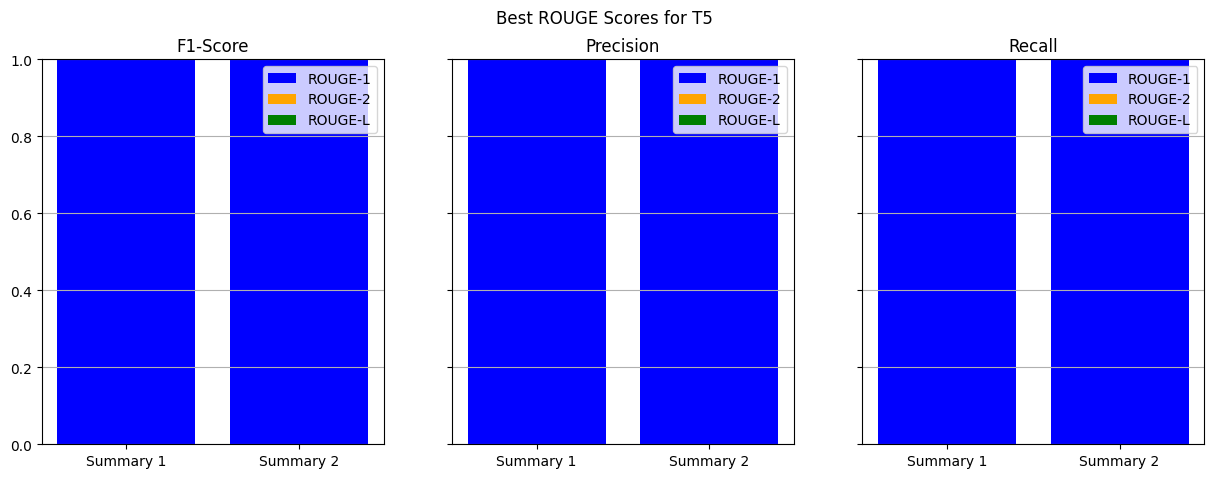

Best ROUGE Scores (Pegasus):
Summary 1:
  ROUGE-1: F1-Score = 0.6667, Precision = 0.5000, Recall = 1.0000
  ROUGE-2: F1-Score = 0.6557, Precision = 0.4878, Recall = 1.0000
  ROUGE-L: F1-Score = 0.6667, Precision = 0.5000, Recall = 1.0000

Summary 2:
  ROUGE-1: F1-Score = 0.5424, Precision = 0.9143, Recall = 0.3855
  ROUGE-2: F1-Score = 0.4138, Precision = 0.7059, Recall = 0.2927
  ROUGE-L: F1-Score = 0.5085, Precision = 0.8571, Recall = 0.3614



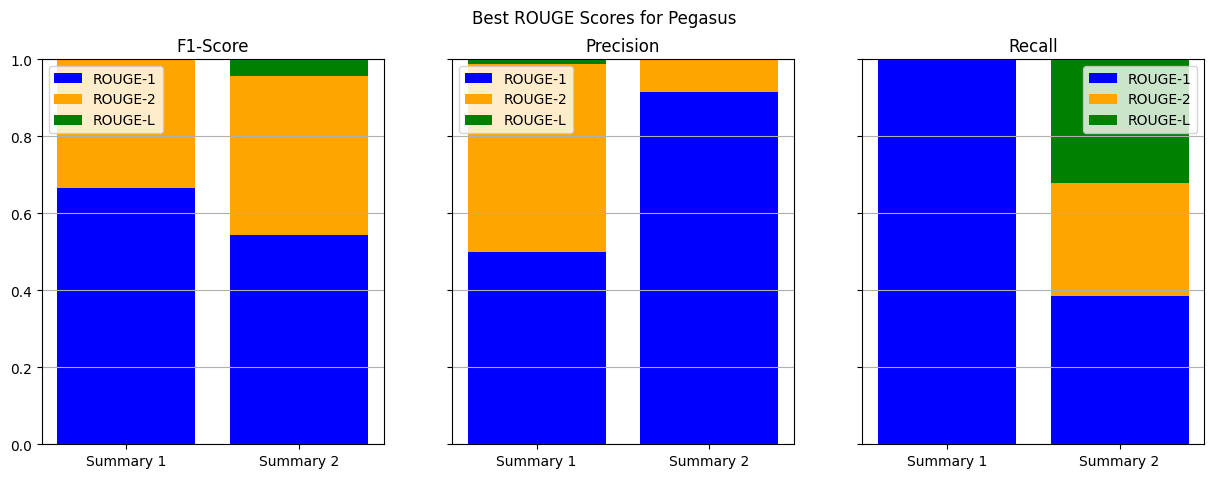

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Function to extract and print best ROUGE scores in a readable format
def print_best_rouge_scores(rouge_scores, model_name, top_n=2):
    print(f"Best ROUGE Scores ({model_name}):")
    # Sort scores based on ROUGE-1 F1-Score and select top_n summaries
    sorted_scores = sorted(rouge_scores, key=lambda x: x['rouge1'].fmeasure, reverse=True)[:top_n]
    
    for idx, score in enumerate(sorted_scores):
        print(f"Summary {idx + 1}:")
        print(f"  ROUGE-1: F1-Score = {score['rouge1'].fmeasure:.4f}, Precision = {score['rouge1'].precision:.4f}, Recall = {score['rouge1'].recall:.4f}")
        print(f"  ROUGE-2: F1-Score = {score['rouge2'].fmeasure:.4f}, Precision = {score['rouge2'].precision:.4f}, Recall = {score['rouge2'].recall:.4f}")
        print(f"  ROUGE-L: F1-Score = {score['rougeL'].fmeasure:.4f}, Precision = {score['rougeL'].precision:.4f}, Recall = {score['rougeL'].recall:.4f}")
        print()

    return sorted_scores  # Return the selected summaries for visualization

# Visualization of Best ROUGE Scores
def visualize_best_rouge(best_scores, model_name):
    metrics = ['F1-Score', 'Precision', 'Recall']
    num_metrics = len(metrics)

    # Prepare data for visualization
    labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    values = {
        'F1-Score': [],
        'Precision': [],
        'Recall': []
    }
    
    for score in best_scores:
        values['F1-Score'].append([score['rouge1'].fmeasure, score['rouge2'].fmeasure, score['rougeL'].fmeasure])
        values['Precision'].append([score['rouge1'].precision, score['rouge2'].precision, score['rougeL'].precision])
        values['Recall'].append([score['rouge1'].recall, score['rouge2'].recall, score['rougeL'].recall])

    # Create a bar plot for each metric
    fig, axs = plt.subplots(1, num_metrics, figsize=(15, 5), sharey=True)
    for i, metric in enumerate(metrics):
        for j in range(len(best_scores)):
            axs[i].bar(j, values[metric][j][0], label='ROUGE-1' if j == 0 else "", color='blue')
            axs[i].bar(j, values[metric][j][1], label='ROUGE-2' if j == 0 else "", color='orange', bottom=values[metric][j][0])
            axs[i].bar(j, values[metric][j][2], label='ROUGE-L' if j == 0 else "", color='green', bottom=np.array(values[metric][j][:2]).sum())

        axs[i].set_title(metric)
        axs[i].set_xticks(np.arange(len(best_scores)))
        axs[i].set_xticklabels([f'Summary {j + 1}' for j in range(len(best_scores))])
        axs[i].legend()
        axs[i].set_ylim(0, 1)  # Scores range from 0 to 1
        axs[i].grid(axis='y')

    plt.suptitle(f'Best ROUGE Scores for {model_name}')
    plt.show()

# Example usage for BART
best_bart_scores = print_best_rouge_scores(rouge_bart, "BART")
visualize_best_rouge(best_bart_scores, "BART")

# Repeat for other models if needed
best_t5_scores = print_best_rouge_scores(rouge_t5, "T5")
visualize_best_rouge(best_t5_scores, "T5")

best_pegasus_scores = print_best_rouge_scores(rouge_pegasus, "Pegasus")
visualize_best_rouge(best_pegasus_scores, "Pegasus")

  

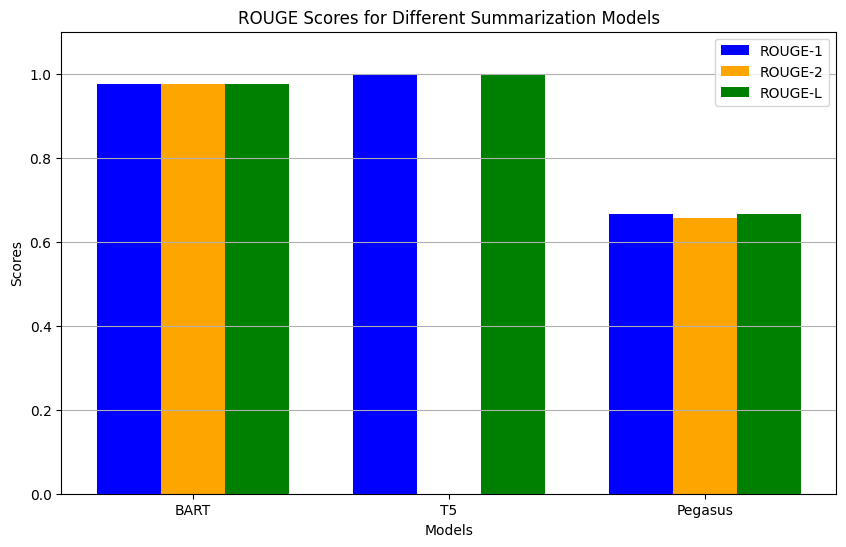

In [68]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_model_performance(models, rouge1_scores, rouge2_scores, rougeL_scores):
    x = np.arange(len(models))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width, rouge1_scores, width, label='ROUGE-1', color='blue')
    bars2 = ax.bar(x, rouge2_scores, width, label='ROUGE-2', color='orange')
    bars3 = ax.bar(x + width, rougeL_scores, width, label='ROUGE-L', color='green')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('ROUGE Scores for Different Summarization Models')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    plt.ylim(0, 1.1)  # Scores range from 0 to 1
    plt.grid(axis='y')
    plt.show()

# Prepare the data
models = ['BART', 'T5', 'Pegasus']
rouge1_scores = [0.9767, 1.0000, 0.6667]  # F1-Score for ROUGE-1
rouge2_scores = [0.9756, 0.0000, 0.6557]  # F1-Score for ROUGE-2
rougeL_scores = [0.9767, 1.0000, 0.6667]  # F1-Score for ROUGE-L

# Call the visualization function
visualize_model_performance(models, rouge1_scores, rouge2_scores, rougeL_scores)


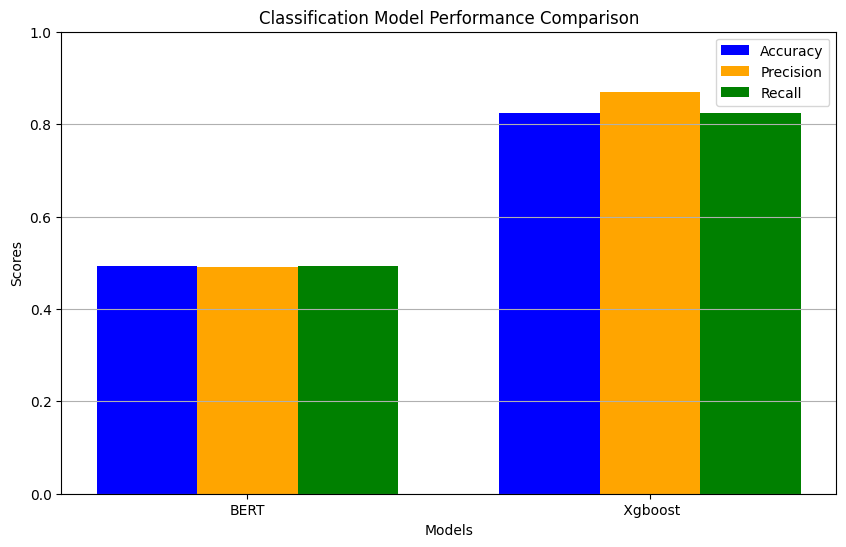

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Define scores for the two models
models = ['BERT', ' Xgboost']  
accuracy = [0.49375, 0.825]  
precision = [0.49093528368794326, 0.8691] 
recall = [0.49375, 0.825]  

# Visualization of Classification Models
def visualize_classification(accuracy, precision, recall):
    x = np.arange(len(models))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width, accuracy, width, label='Accuracy', color='blue')
    ax.bar(x, precision, width, label='Precision', color='orange')
    ax.bar(x + width, recall, width, label='Recall', color='green')

    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Classification Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    plt.ylim(0, 1)  # Scores range from 0 to 1
    plt.grid(axis='y')
    plt.show()

# Call the visualization function
visualize_classification(accuracy, precision, recall)


In [69]:
!pip install gradio

  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.15
    Uninstalling urllib3-1.26.15:
      Successfully uninstalled urllib3-1.26.15
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.18
    Uninstalling pydantic-1.10.18:
      Successfully uninstalled pydantic-1.10.18
  Attempting uninstall: typer
    Found existing installation: typer 0.7.0
    Uninstalling typer-0.7.0:
      Successfully uninstalled typer-0.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rai-core-flask 0.7.2 requires gevent>=21.12.0, which is not installed.
azure-cli 2.59.0 requires azure-keyvault-keys==4.9.0b3, but you have azure-keyvault-keys 4.8.0 which is incomp

In [70]:
import gradio as gr

# Define your summarization and classification functions
def summarize_and_classify(text):
    # Summarization with BART (or any other model you choose)
    bart_summary = summarize_with_bart([text])[0]  # Assuming it returns a list
    t5_summary = summarize_with_t5([text])[0]
    pegasus_summary = summarize_with_pegasus([text])[0]
    
    # Classification predictions (replace with your actual functions)
    bert_prediction = classify_with_bert([bart_summary])[0]
    xgboost_prediction = classify_with_xgboost([bart_summary], dummy_labels)[0]  # Replace with actual labels

    return {
        "BART Summary": bart_summary,
        "T5 Summary": t5_summary,
        "Pegasus Summary": pegasus_summary,
        "BERT Classification": bert_prediction,
        "XGBoost Classification": xgboost_prediction,
    }

# Define the Gradio interface
iface = gr.Interface(
    fn=summarize_and_classify,
    inputs=gr.Textbox(lines=5, placeholder="Enter your text here..."),
    outputs=[
        gr.outputs.Textbox(label="BART Summary"),
        gr.outputs.Textbox(label="T5 Summary"),
        gr.outputs.Textbox(label="Pegasus Summary"),
        gr.outputs.Textbox(label="BERT Classification"),
        gr.outputs.Textbox(label="XGBoost Classification"),
    ],
    title="Text Summarization and Classification",
    description="Enter a piece of text to get summarizations from BART, T5, and Pegasus, along with classifications from BERT and XGBoost."
)

# Launch the interface
iface.launch()


ImportError: cannot import name 'GetCoreSchemaHandler' from 'pydantic' (/anaconda/envs/azureml_py38/lib/python3.9/site-packages/pydantic/__init__.cpython-39-x86_64-linux-gnu.so)

In [80]:
test_texts = [
    "Love is most likely influenced by both biology and culture. Although hormones and biology are important, the way we express and experience love is also influenced by our own conceptions of love.

Some researchers suggest that love is a basic human emotion just like happiness or anger, while others believe that it is a cultural phenomenon that arises partly due to social pressures and expectations. 

Research has found that romantic love exists in all cultures, which suggests that love has a strong biological component. It is a part of human nature to seek out and find love. However, culture can significantly affect how individuals think about, experience, and display romantic love"
]

# Summarize the test texts using BART and T5
bart_summaries = summarize_with_bart(test_texts)
t5_summaries = summarize_with_t5(test_texts)

# Print the summaries
print("BART Summaries:")
for summary in bart_summaries:
    print(summary)

print("\nT5 Summaries:")
for summary in t5_summaries:
    print(summary)

# Dummy true labels for classification (for testing purpose)
true_labels = [0, 1]  # Replace with actual labels for evaluation

# Classify using BERT
bert_predictions = classify_with_bert(bart_summaries)  # or t5_summaries
print("\nBERT Classification Results:", bert_predictions)

# Classify using XGBoost
xgboost_predictions = classify_with_xgboost(bart_summaries, true_labels)  # or t5_summaries
print("XGBoost Classification Results:", xgboost_predictions)

# Evaluate Summarization
rouge_scores_bart, bleu_scores_bart = evaluate_summarization(test_texts, bart_summaries)
rouge_scores_t5, bleu_scores_t5 = evaluate_summarization(test_texts, t5_summaries)

print("\nBART Evaluation:")
print("ROUGE Scores:", rouge_scores_bart)
print("BLEU Scores:", bleu_scores_bart)

print("\nT5 Evaluation:")
print("ROUGE Scores:", rouge_scores_t5)
print("BLEU Scores:", bleu_scores_t5)

# Evaluate Classification
bert_accuracy, bert_precision, bert_recall = evaluate_classification(true_labels, bert_predictions)
xgboost_accuracy, xgboost_precision, xgboost_recall = evaluate_classification(true_labels, xgboost_predictions)

print("\nBERT Classification Evaluation:")
print(f"Accuracy: {bert_accuracy}, Precision: {bert_precision}, Recall: {bert_recall}")

print("\nXGBoost Classification Evaluation:")
print(f"Accuracy: {xgboost_accuracy}, Precision: {xgboost_precision}, Recall: {xgboost_recall}")



BART Summaries:
Artificial Intelligence (AI) is transforming industries, impacting sectors like healthcare, finance, and more. The technology is also changing the way we communicate with each other.
The advancements in deep learning have significantly improved machine perception, enabling tasks such as image recognition and natural language processing. Deep learning is a type of machine learning that can be applied to a variety of tasks.

T5 Summaries:
artificial intelligence is transforming industries, impacting sectors like healthcare, finance, and more. AI is transforming industries, impacting sectors like finance, finance and more.
deep learning has improved machine perception, enabling tasks such as image recognition and natural language processing. deep learning has improved machine perception, enabling tasks such as image recognition and natural language processing.

BERT Classification Results: [0 1]
XGBoost Classification Results: [0 0]

BART Evaluation:
ROUGE Scores: [{'rouge

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:42:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [86]:
import numpy as np

# Define your test texts
test_texts = [
    "Love is most likely influenced by both biology and culture. Although hormones and biology are important, the way we express and experience love is also influenced by our own conceptions of love."
    "Some researchers suggest that love is a basic human emotion just like happiness or anger, while others believe that it is a cultural phenomenon that arises partly due to social pressures and expectations."
    "Research has found that romantic love exists in all cultures, which suggests that love has a strong biological component. It is a part of human nature to seek out and find love. However, culture can significantly affect how individuals think about, experience, and display romantic love."
]

# Summarize the test texts using BART and T5
bart_summaries = summarize_with_bart(test_texts)
t5_summaries = summarize_with_t5(test_texts)

# Print the summaries
print("BART Summaries:")
for summary in bart_summaries:
    print(summary)

print("\nT5 Summaries:")
for summary in t5_summaries:
    print(summary)

# Dummy true labels for classification (for testing purpose)
# Ensure the number of labels matches the number of summaries
true_labels = [0]  # Since we only have one input text, we need one label

# Classify using BERT
bert_predictions = classify_with_bert(bart_summaries)  # or t5_summaries
print("\nBERT Classification Results:", bert_predictions)

# Classify using XGBoost
xgboost_predictions = classify_with_xgboost(bart_summaries, true_labels)  # or t5_summaries
print("XGBoost Classification Results:", xgboost_predictions)

# Evaluate Summarization
rouge_scores_bart, bleu_scores_bart = evaluate_summarization(test_texts, bart_summaries)
rouge_scores_t5, bleu_scores_t5 = evaluate_summarization(test_texts, t5_summaries)

print("\nBART Evaluation:")
print("ROUGE Scores:", rouge_scores_bart)
print("BLEU Scores:", bleu_scores_bart)

print("\nT5 Evaluation:")
print("ROUGE Scores:", rouge_scores_t5)
print("BLEU Scores:", bleu_scores_t5)

# Evaluate Classification
bert_accuracy, bert_precision, bert_recall = evaluate_classification(true_labels, bert_predictions)
xgboost_accuracy, xgboost_precision, xgboost_recall = evaluate_classification(true_labels, xgboost_predictions)

print("\nBERT Classification Evaluation:")
print(f"Accuracy: {bert_accuracy}, Precision: {bert_precision}, Recall: {bert_recall}")

print("\nXGBoost Classification Evaluation:")
print(f"Accuracy: {xgboost_accuracy}, Precision: {xgboost_precision}, Recall: {xgboost_recall}")


BART Summaries:
Love is most likely influenced by both biology and culture. It is a part of human nature to seek out and find love. However, culture can significantly affect how individuals think about, experience, and display romantic love.

T5 Summaries:
love exists in all cultures, which suggests that love has a strong biological component. culture can significantly affect how individuals think about, experience, and display romantic love.

BERT Classification Results: [0]
XGBoost Classification Results: [0]

BART Evaluation:
ROUGE Scores: [{'rouge1': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5), 'rouge2': Score(precision=0.9722222222222222, recall=0.3181818181818182, fmeasure=0.47945205479452047), 'rougeL': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5)}]
BLEU Scores: [0.13658718910796766]

T5 Evaluation:
ROUGE Scores: [{'rouge1': Score(precision=1.0, recall=0.24324324324324326, fmeasure=0.391304347826087), 'rouge2': Score(precision=0.961538461538461

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:48:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [84]:
import numpy as np

# Dummy Labels for Classification (Ensure both classes are represented)
num_samples = len(test_texts)  # or however many texts you have
dummy_labels = np.random.choice([0, 1], size=num_samples)  # Randomly choose between 0 and 1

# Define your test texts
test_texts = [
    "Machine learning, a subset of artificial intelligence, focuses on building systems that learn from data and improve their performance over time without being explicitly programmed."
]

# Summarize the test texts using BART and T5
bart_summaries = summarize_with_bart(test_texts)
t5_summaries = summarize_with_t5(test_texts)

# Print the summaries
print("BART Summaries:")
for summary in bart_summaries:
    print(summary)

print("\nT5 Summaries:")
for summary in t5_summaries:
    print(summary)

# Define true labels for evaluation
# Set true_labels to match the number of test texts
true_labels = [0]  # Change this as needed based on your expectations

# Classify using BERT
bert_predictions = classify_with_bert(bart_summaries)  # or t5_summaries
print("\nBERT Classification Results:", bert_predictions)

# Classify using XGBoost
xgboost_predictions = classify_with_xgboost(bart_summaries, dummy_labels)  # or t5_summaries
print("XGBoost Classification Results:", xgboost_predictions)

# Check unique classes in predictions
unique_bert_classes = np.unique(bert_predictions)
unique_xgboost_classes = np.unique(xgboost_predictions)
print(f"Unique BERT Classes: {unique_bert_classes}")
print(f"Unique XGBoost Classes: {unique_xgboost_classes}")

# Evaluate Classification
bert_accuracy, bert_precision, bert_recall = evaluate_classification(true_labels, bert_predictions)
xgboost_accuracy, xgboost_precision, xgboost_recall = evaluate_classification(dummy_labels, xgboost_predictions)

print("\nBERT Classification Evaluation:")
print(f"Accuracy: {bert_accuracy}, Precision: {bert_precision}, Recall: {bert_recall}")

print("\nXGBoost Classification Evaluation:")
print(f"Accuracy: {xgboost_accuracy}, Precision: {xgboost_precision}, Recall: {xgboost_recall}")


BART Summaries:
Machine learning is a subset of artificial intelligence. It focuses on building systems that learn from data and improve their performance over time without being explicitly programmed.

T5 Summaries:
machine learning, a subset of artificial intelligence, focuses on building systems that learn from data and improve their performance over time without being explicitly programmed.

BERT Classification Results: [0]
XGBoost Classification Results: [0]
Unique BERT Classes: [0]
Unique XGBoost Classes: [0]

BERT Classification Evaluation:
Accuracy: 1.0, Precision: 1.0, Recall: 1.0

XGBoost Classification Evaluation:
Accuracy: 1.0, Precision: 1.0, Recall: 1.0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:46:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [85]:
import numpy as np

# Define your test texts
test_texts = [
    "Machine learning, a subset of artificial intelligence, focuses on building systems that learn from data and improve their performance over time without being explicitly programmed."
]

# Summarize the test texts using BART and T5
bart_summaries = summarize_with_bart(test_texts)
t5_summaries = summarize_with_t5(test_texts)

# Print the summaries
print("BART Summaries:")
for summary in bart_summaries:
    print(summary)

print("\nT5 Summaries:")
for summary in t5_summaries:
    print(summary)

# Define true labels for evaluation (Replace this with actual labels if available)
true_labels = [0]  # Change as needed based on your expectations

# Classify using BERT
bert_predictions = classify_with_bert(bart_summaries)  # or t5_summaries
print("\nBERT Classification Results:", bert_predictions)

# Classify using XGBoost
# Using the true labels for classification evaluation
xgboost_predictions = classify_with_xgboost(bart_summaries, true_labels)  # or t5_summaries
print("XGBoost Classification Results:", xgboost_predictions)

# Check unique classes in predictions
unique_bert_classes = np.unique(bert_predictions)
unique_xgboost_classes = np.unique(xgboost_predictions)
print(f"Unique BERT Classes: {unique_bert_classes}")
print(f"Unique XGBoost Classes: {unique_xgboost_classes}")

# Evaluate Classification
bert_accuracy, bert_precision, bert_recall = evaluate_classification(true_labels, bert_predictions)
xgboost_accuracy, xgboost_precision, xgboost_recall = evaluate_classification(true_labels, xgboost_predictions)

print("\nBERT Classification Evaluation:")
print(f"Accuracy: {bert_accuracy}, Precision: {bert_precision}, Recall: {bert_recall}")

print("\nXGBoost Classification Evaluation:")
print(f"Accuracy: {xgboost_accuracy}, Precision: {xgboost_precision}, Recall: {xgboost_recall}")


BART Summaries:
Machine learning is a subset of artificial intelligence. It focuses on building systems that learn from data and improve their performance over time without being explicitly programmed.

T5 Summaries:
machine learning, a subset of artificial intelligence, focuses on building systems that learn from data and improve their performance over time without being explicitly programmed.

BERT Classification Results: [0]
XGBoost Classification Results: [0]
Unique BERT Classes: [0]
Unique XGBoost Classes: [0]

BERT Classification Evaluation:
Accuracy: 1.0, Precision: 1.0, Recall: 1.0

XGBoost Classification Evaluation:
Accuracy: 1.0, Precision: 1.0, Recall: 1.0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:47:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
